# Import Packages

In [1]:
%matplotlib inline
from ipywidgets import HTML
import ipywidgets as widgets
from ipyleaflet import Map, Polyline, Rectangle, basemaps, basemap_to_tiles, Polygon, FullScreenControl, Popup, WidgetControl
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import itertools

import sys
sys.path.append('/datc/saab/notebooks')

# Import & clean Data

In [2]:
"""filename = '/datc/saab/ANONIMISED_trackdata_small_export_HH_proj_anomalydetection.csv'
data = pd.read_csv(filename)"""

from saab import datasets
data = datasets.reduced_area_delta()

data.latitude = data['latitude'] + 47.72
data.longitude = data['longitude'] + 157.85

"""
from saab import datasets
data = datasets.new_ship_length()
data = data.dropna()
data = data[data.length>0]"""
data.head()

,mmsi,datetime,latitude,longitude,orientation,rateofturn,course,length,breadth,speed,vesseltype,delta
26806187,32,2018-12-01 07:11:07.206,22.155962,114.174393,29.0000,0.0,348.75,33.8125,4.199219,4.250000,0,00:00:02.999000
26807919,32,2018-12-01 07:11:10.207,22.156080,114.174371,57.0000,0.0,349.00,33.8125,4.199219,4.261719,0,00:00:03.001000
26809640,32,2018-12-01 07:11:13.207,22.156194,114.174348,59.6875,0.0,349.00,33.8125,4.199219,4.261719,0,00:00:03
26811391,32,2018-12-01 07:11:16.206,22.156315,114.174324,64.0000,0.0,349.25,33.8125,4.199219,4.281250,0,00:00:02.999000
26813120,32,2018-12-01 07:11:19.207,22.156431,114.174298,65.0000,0.0,349.00,33.8125,4.199219,4.281250,0,00:00:03.001000


# Define Functions

In [3]:
def traduce_var(data, number_of_partitions, minimum, maximum, quant_borders, percentile=True):
    if not percentile:
        #print('given the data:', data, ' in the range (',minimum,', ',maximum, ')')
        classif = int((data-minimum)*number_of_partitions/(maximum - minimum))
        #print('The classification is:', classif)
        if classif != number_of_partitions:
            return classif
        else:
            return number_of_partitions - 1
    else:
        classification = -1
        for border in quant_borders:
            classification +=1
            if data < border:
                return classification
        return len(quant_borders) - 1
    
def Sort(sub_li, fieldnum): 
  
    # reverse = None (Sorts in Ascending order) 
    # key is set to sort using second element of  
    # sublist lambda has been used 
    return(sorted(sub_li, key = lambda x: x[fieldnum]))

def rotate(point, rot):
    return (point[0]*math.cos(math.radians(rot)) - point[1]*math.sin(math.radians(rot)), 
            point[0]*math.sin(math.radians(rot)) + point[1]*math.cos(math.radians(rot)))

def get_bounds(breadth, length, longitude, latitude, rot_angle):
    #This function gets the real bounds of a boat
    #Knowing that according to: https://en.wikipedia.org/wiki/Decimal_degrees
    #0.00001deg are equal to 1.1132 m
    length = length*0.00001/1.1132
    breadth = breadth*0.00001/1.1132
    
    center_point = np.array((longitude, latitude))
    
    ship_shape_ini = [(-breadth/2, length/2), (breadth/2, length/2), (breadth/2, -length/2), (-breadth/2, -length/2)]
    
    ship_shape_rot = [np.array(rotate(point, rot_angle)) for point in ship_shape_ini]
    
    xy1 = list(ship_shape_rot[0] + center_point)
    xy2 = list(ship_shape_rot[1] + center_point)
    xy3 = list(ship_shape_rot[2] + center_point)
    xy4 = list(ship_shape_rot[3] + center_point)
    
    return [xy1,xy2,xy3,xy4]

def get_color_scale(arr, scale_type='plasma'):
    arr = list(arr)
    #https://matplotlib.org/gallery/color/colormap_reference.html
    scale = cm.get_cmap(scale_type, len(arr)).colors
    
    arr = np.array(arr)
    sorted_index = np.argsort(arr)
    return {arr[sorted_index[i]]:rgb_to_hex(scale[i]) for i in range(len(arr))}

def rgb_to_hex(rgb):
    if len(rgb) == 4:
        rgb = rgb[:3]
    return '#%02x%02x%02x' % tuple(list([int(elem*256) for elem in rgb]))
def random_hex_color():
    import random
    r = lambda: random.randint(0,255)
    return ('#%02X%02X%02X' % (r(),r(),r()))

# Get variables from data

In [24]:
#Variables in which we willfocus on
variables = ['speed','length']
partitions_number = [10,10]
train_percent = 0.6

In [25]:
%%time
#Get maximum and minimum values of the variables
maxminvalues = []
for var in variables:
    maxminvalues.append([data[var].min(), data[var].max()])
print(maxminvalues)

quantile_borders = [[] for var in variables]
for i, var in enumerate(variables):
    step = 1/partitions_number[i]
    data_var = data[var]
    npdata_var = data_var.values
    for j in range(0, partitions_number[i]):
        #print('DF Cuantile ', j, (j+1)*step, float(data_var.quantile((j+1)*step)))
        print('NP Cuantile ', j, (j+1)*step*100, float(np.percentile(npdata_var, ((j+1)*step*100))))
        quantile_borders[i].append(float(np.percentile(npdata_var, ((j+1)*step*100))))

[[0.0, 44.34], [0.0, 397.8]]
NP Cuantile  0 10.0 0.1800537109375
NP Cuantile  1 20.0 0.72998046875
NP Cuantile  2 30.000000000000004 2.7109375
NP Cuantile  3 40.0 3.33984375
NP Cuantile  4 50.0 3.75
NP Cuantile  5 60.00000000000001 4.12109375
NP Cuantile  6 70.0 4.571093749999818
NP Cuantile  7 80.0 5.16015625
NP Cuantile  8 90.0 6.890625
NP Cuantile  9 100.0 44.34375
NP Cuantile  0 10.0 14.0
NP Cuantile  1 20.0 22.0
NP Cuantile  2 30.000000000000004 27.0
NP Cuantile  3 40.0 31.296875
NP Cuantile  4 50.0 40.0
NP Cuantile  5 60.00000000000001 50.59375
NP Cuantile  6 70.0 75.0
NP Cuantile  7 80.0 143.25
NP Cuantile  8 90.0 208.75
NP Cuantile  9 100.0 397.75
CPU times: user 190 ms, sys: 0 ns, total: 190 ms
Wall time: 187 ms


# Get a list of lists containing the sorted points of every ship

In [26]:
%%time
ships_info = []

for ship in data.sort_values(by=['mmsi', 'datetime']).groupby('mmsi').apply(lambda g: g[['mmsi', 'latitude', 'longitude'] + variables + ['datetime']].values):
    ships_info.append(ship)
ships_info = np.array(ships_info)

CPU times: user 2.58 s, sys: 121 ms, total: 2.7 s
Wall time: 2.7 s


# Split the ships data into training and test

In [27]:
border = int(train_percent*len(ships_info))

ranges = [list(range(part)) for part in partitions_number]
print(ranges)
states = list(itertools.product(*ranges))
indx_transitions = {}
for i in range(len(states)):
    indx_transitions[states[i]] = i
print('Final number of states: ', len(states))

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]
Final number of states:  100


# Translating all the transitions to state notation

In [28]:
ships_info_states = [] #ships_info traduced to state-notation
ship_n = 0

for ship in ships_info:
    ship_n += 1
    print(ship_n, ' out of ', len(ships_info))
    ships_info_states.append([])

    for i in range(len(ship)-1):
        point = ship[i]
        temporal = []
        for i in range(len(variables)):
            temporal.append(traduce_var(point[i+3], partitions_number[i], maxminvalues[i][0], maxminvalues[i][1], quantile_borders[i]))
            #temporal.append(traduce_var_percentile(point[i+3], quantile_borders[i]))
        ships_info_states[-1].append(indx_transitions[tuple(temporal)])

1  out of  499
2  out of  499
3  out of  499
4  out of  499
5  out of  499
6  out of  499
7  out of  499
8  out of  499
9  out of  499
10  out of  499
11  out of  499
12  out of  499
13  out of  499
14  out of  499
15  out of  499
16  out of  499
17  out of  499
18  out of  499
19  out of  499
20  out of  499
21  out of  499
22  out of  499
23  out of  499
24  out of  499
25  out of  499
26  out of  499
27  out of  499
28  out of  499
29  out of  499
30  out of  499
31  out of  499
32  out of  499
33  out of  499
34  out of  499
35  out of  499
36  out of  499
37  out of  499
38  out of  499
39  out of  499
40  out of  499
41  out of  499
42  out of  499
43  out of  499
44  out of  499
45  out of  499
46  out of  499
47  out of  499
48  out of  499
49  out of  499
50  out of  499
51  out of  499
52  out of  499
53  out of  499
54  out of  499
55  out of  499
56  out of  499
57  out of  499
58  out of  499
59  out of  499
60  out of  499
61  out of  499
62  out of  499
63  out of  499
6

In [29]:
ships_info_states[:3]

[[64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64,
  64

In [30]:
from sklearn.model_selection import train_test_split
ships_info_train, ships_info_test = train_test_split(ships_info_states)

# Create the transition probability matrix (tpm)
By default the probability of being in an state and keep in it is 1

In [31]:
tpm = np.identity((len(states)))
print('Initially: \n', tpm)

Initially: 
 [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


## Calculate the probabilities for each transition

In [32]:
transition = {}
finishing_at = {}

for ship in ships_info_train:
    for i in range(len(ship)-1):
        current_state = ship[i]
        next_state = ship[i+1]
        if current_state != next_state:
            if next_state not in finishing_at.keys():
                finishing_at[next_state] = 1
            else:
                finishing_at[next_state] += 1

            if (current_state, next_state) not in transition.keys():
                transition[(current_state, next_state)] = 1
            else:
                transition[(current_state, next_state)] += 1

In [33]:
print(transition)

{(97, 87): 10, (87, 77): 94, (77, 67): 87, (67, 57): 87, (57, 47): 195, (47, 37): 145, (37, 47): 160, (47, 57): 201, (57, 67): 92, (67, 77): 94, (77, 87): 97, (87, 97): 10, (0, 23): 1, (23, 63): 3, (63, 53): 90, (53, 63): 89, (53, 54): 30, (54, 64): 123, (64, 65): 33, (65, 55): 85, (55, 45): 142, (45, 35): 239, (35, 25): 87, (25, 35): 90, (35, 45): 236, (45, 55): 135, (55, 65): 80, (45, 44): 10, (44, 54): 127, (54, 44): 133, (54, 63): 1, (63, 43): 8, (43, 33): 125, (33, 43): 118, (43, 53): 64, (53, 43): 69, (56, 46): 142, (46, 56): 132, (56, 66): 153, (66, 56): 156, (46, 36): 224, (36, 26): 54, (26, 16): 44, (16, 26): 44, (26, 6): 3, (5, 15): 179, (15, 25): 60, (45, 65): 8, (25, 15): 70, (15, 5): 191, (5, 25): 8, (37, 27): 54, (45, 47): 2, (27, 37): 55, (27, 25): 19, (25, 45): 3, (25, 27): 16, (37, 35): 11, (15, 17): 1, (17, 27): 125, (27, 26): 65, (26, 36): 53, (36, 66): 2, (66, 76): 82, (76, 46): 1, (26, 25): 23, (35, 37): 19, (37, 67): 3, (37, 25): 1, (35, 55): 6, (37, 36): 23, (36,

### Fulfilling the tpm

In [34]:
for i in range(len(states)):
    for j in range(len(states)):
        if (i, j) in transition.keys():
            #tpm[i][j] = transition[(i, j)]/starting_at[i]
            tpm[i][j] = transition[(i,j)]/finishing_at[i]

### Visualising the tpm

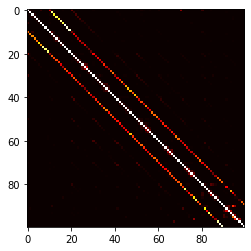

In [35]:
"""import seaborn as sns
norm_tpm = tpm/tpm.max()
ax = sns.heatmap(norm_tpm)
plt.show()"""


plt.imshow(tpm,cmap='hot', interpolation='nearest')
#print(np.sort(np.unique(tpm.reshape(1, 100000000)[0]))[5000:])

# Translating from states notation to probabilities notation according to the tpm

In [36]:
probability_chains = []
for ship in ships_info_states[border:]:
    probability_chains.append([])
    for i in range(len(ship)-1):
        probability_chains[-1].append(tpm[ship[i]][ship[i+1]])

In [37]:
tpm[ship[i]][ship[i+1]]

1.0

# Taking apart the anomalous transitions (p<0.01)

In [38]:
anomalous_transitions =  [[] for i in range(len(ships_info[border:]))]
anomalous_transitions_index = [[] for i in range(len(ships_info[border:]))]
anomalous_probabilities = [[] for i in range(len(ships_info[border:]))]
for i, chain in enumerate(probability_chains):
    print(chain)
    for j, p in enumerate(chain):
        if p < 0.01:
            anomalous_probabilities[i].append(p)
            anomalous_transitions_index[i].append(j)
            anomalous_transitions[i].append([ships_info[border+i][j], ships_info[border+i][j+1]])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4528301886792453, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5144230769230769, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

# GeoVisualization of the results

In [39]:
m = Map(center = (22.205232, 114.123882), zoom = 12)#Define the map object

#To define  the maximum number of steps we will be able to take with the slider
max_steps = len(ships_info[border:])
ships_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=max_steps,
    step=1,
    description='Ships: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
widget_steps = WidgetControl(widget=ships_slider, position='topright')
m.add_control(widget_steps)
m.add_control(FullScreenControl())
dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.DarkMatter)
m.add_layer(dark_matter_layer)
previous_value = 0


def update_map(ships_slider):
    global previous_value, m
    if previous_value > ships_slider:
        m = Map(center = (-22.884059, 133.714373), zoom =4)#Define the map object
        ini, end = 0, ships_slider
    else:
        ini, end = previous_value, ships_slider
        
        
    for i in range(ini, end):
        plt.figure(figsize=(10,8))
        color_value = 'green'
        #for each time series in ships_info list --> Paint The line
        line = Polyline(
            locations = [[elem[1],elem[2]] for elem in ships_info[border+i]],
            color = 'green',
            fill_color= "transparent",
            weight = 3,
            opacity = 0.4)
        m.add_layer(line)
        
        plt.plot([elem[-1] for j, elem in enumerate(ships_info[border+i])],
                 [elem[3] for j, elem in enumerate(ships_info[border+i])], c='green', alpha=0.7)
        plt.title('Ship LENGTH: ' + str(ships_info[border+i][0][4]))

        for anom_n, anomaly in enumerate(anomalous_transitions[i]):
            plt.plot([elem[-1] for elem in anomaly],
                     [elem[3] for elem in anomaly], c='red')
            line_anom = Polyline(
                locations = [[elem[1],elem[2]] for elem in anomaly],
                color = 'red',
                fill_color= "transparent",
                weight = 2,
                opacity = 1)
            m.add_layer(line_anom)
            singular_info = anomaly[0]
            """message = HTML()
            message.value = '<b>**DATE: <br>' + str(singular_info[-1]) + '**</b><br><b>Longitude</b>: ' + str(singular_info[1]) + '<br><b>Latitude</b>:  ' + str(singular_info[2]) + "<br><b>Vessel's Variables</b>: " + str(singular_info[3:5]))#[47771, -25.455258050999998, -43.748200231999995, 123.375, 161.875, Timestamp('2018-11-30 17:16:36.707000')]
            mapbounds = get_bounds(singular_info[3], singular_info[4], singular_info[0], singular_info[1], singular_info[2])
            ship_shape = Polygon(
            locations=[mapbounds],
            color=color_value,
            fill_color=color_value,
            fill_opacity=1
            )
            ship_shape.popup = message
            m.add_layer(ship_shape)"""
            """            try:
                print('ANOMALY ', anom_n+1, '*** ', anomalous_probabilities[i][anom_n], ' ***')
            except:
                pass
            for i,var in enumerate(variables):
                print(var,': ', anomaly[0][i+3], ' -> ', anomaly[1][i+3], 'in ', (anomaly[1][-1]-anomaly[0][-1]).total_seconds(), ' seconds.')
            print('\n')"""
            """for qborder in quantile_borders[0]:
            if qborder<=max([elem[3] for ship in ships_info[border:] for elem in ship]):
                plt.plot([elem[-1] for j, elem in enumerate(ships_info[border+i])], [qborder]*len([elem[-1] for j, elem in enumerate(ships_info[border+i])]), c='black', alpha=0.2)"""
    
    plt.show()
    previous_value = ships_slider
display(m)
widgets.interactive(update_map, ships_slider=ships_slider)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

interactive(children=(IntSlider(value=0, continuous_update=False, description='Ships: ', max=200), Output()), …

Percentage of anomalies

In [40]:
anom = sum([len(anomalies) for anomalies in anomalous_transitions])
ship_points = sum([len(ship) for ship in ships_info[border:]])
anom/(ship_points-1)*100

0.12056178191513289

Save the map

In [21]:
from ipywidgets.embed import embed_minimal_html
embed_minimal_html('test.html', views=[m, ])

Comparison between linear and quantile partitions

In [22]:
data_test_l = data.length
data_test_s = data.speed

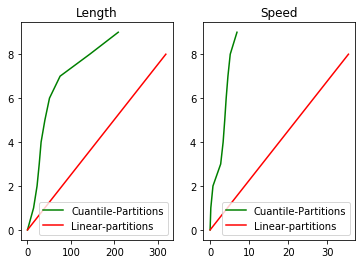

In [23]:
partitions = 10
plt.subplot(121)
plt.plot([data_test_l.quantile(i/partitions) for i in range(partitions)], list(range(partitions)), color='green')
plt.plot([(data_test_l.max()-data_test_l.min())*i/partitions for i in range(partitions-1)], list(range(partitions-1)), color='red')
#plt.hist((data_test_lv-min(data_test_lv))/(max(data_test_lv)-min(data_test_lv)), alpha=0.7)
plt.title('Length')
plt.legend(['Cuantile-Partitions', 'Linear-partitions', 'Points along the axis'])

plt.subplot(122)
plt.plot([data_test_s.quantile(i/partitions) for i in range(partitions)], list(range(partitions)), color='green')
plt.plot([(data_test_s.max()-data_test_s.min())*i/partitions for i in range(partitions-1)], list(range(partitions-1)), color='red')
#plt.hist((data_test_sv-min(data_test_sv))/(max(data_test_sv)-min(data_test_sv)), alpha=0.7)
plt.title('Speed')
plt.legend(['Cuantile-Partitions', 'Linear-partitions', 'Points along the axis'])
plt.show()